In [1]:
from pathlib import Path
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [2]:
# plotting settings
DATAROOT = Path("../data")
FIGROOT = Path("../fig")
FIGDPI = 600
FIGSUFFIX = ".pdf"

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "savefig.pad_inches": 0.05 / 2.54,
        "grid.linewidth": 0.25,
        "axes.titlesize": 8,
        "axes.titlepad": 0.05,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
    }
)

In [3]:
GEOEM_FILE = DATAROOT.joinpath("wrf_domain.nc")
with h5netcdf.File(GEOEM_FILE, "r") as f:
    lon = np.array(f.variables["lon"][:], dtype=np.float64)
    lat = np.array(f.variables["lat"][:], dtype=np.float64)
    hgt = np.array(f.variables["HGT"][:, :], dtype=np.float32)

In [4]:
WEIGHT_FILE = DATAROOT.joinpath("rivnet.parquet")
rivnet= pl.read_parquet(WEIGHT_FILE)
print(f"There are {rivnet.height} rivers in the dataset.")

There are 5800 rivers in the dataset.


In [5]:
gauge = pl.read_csv(DATAROOT.joinpath("gauge_q_loc.csv"))

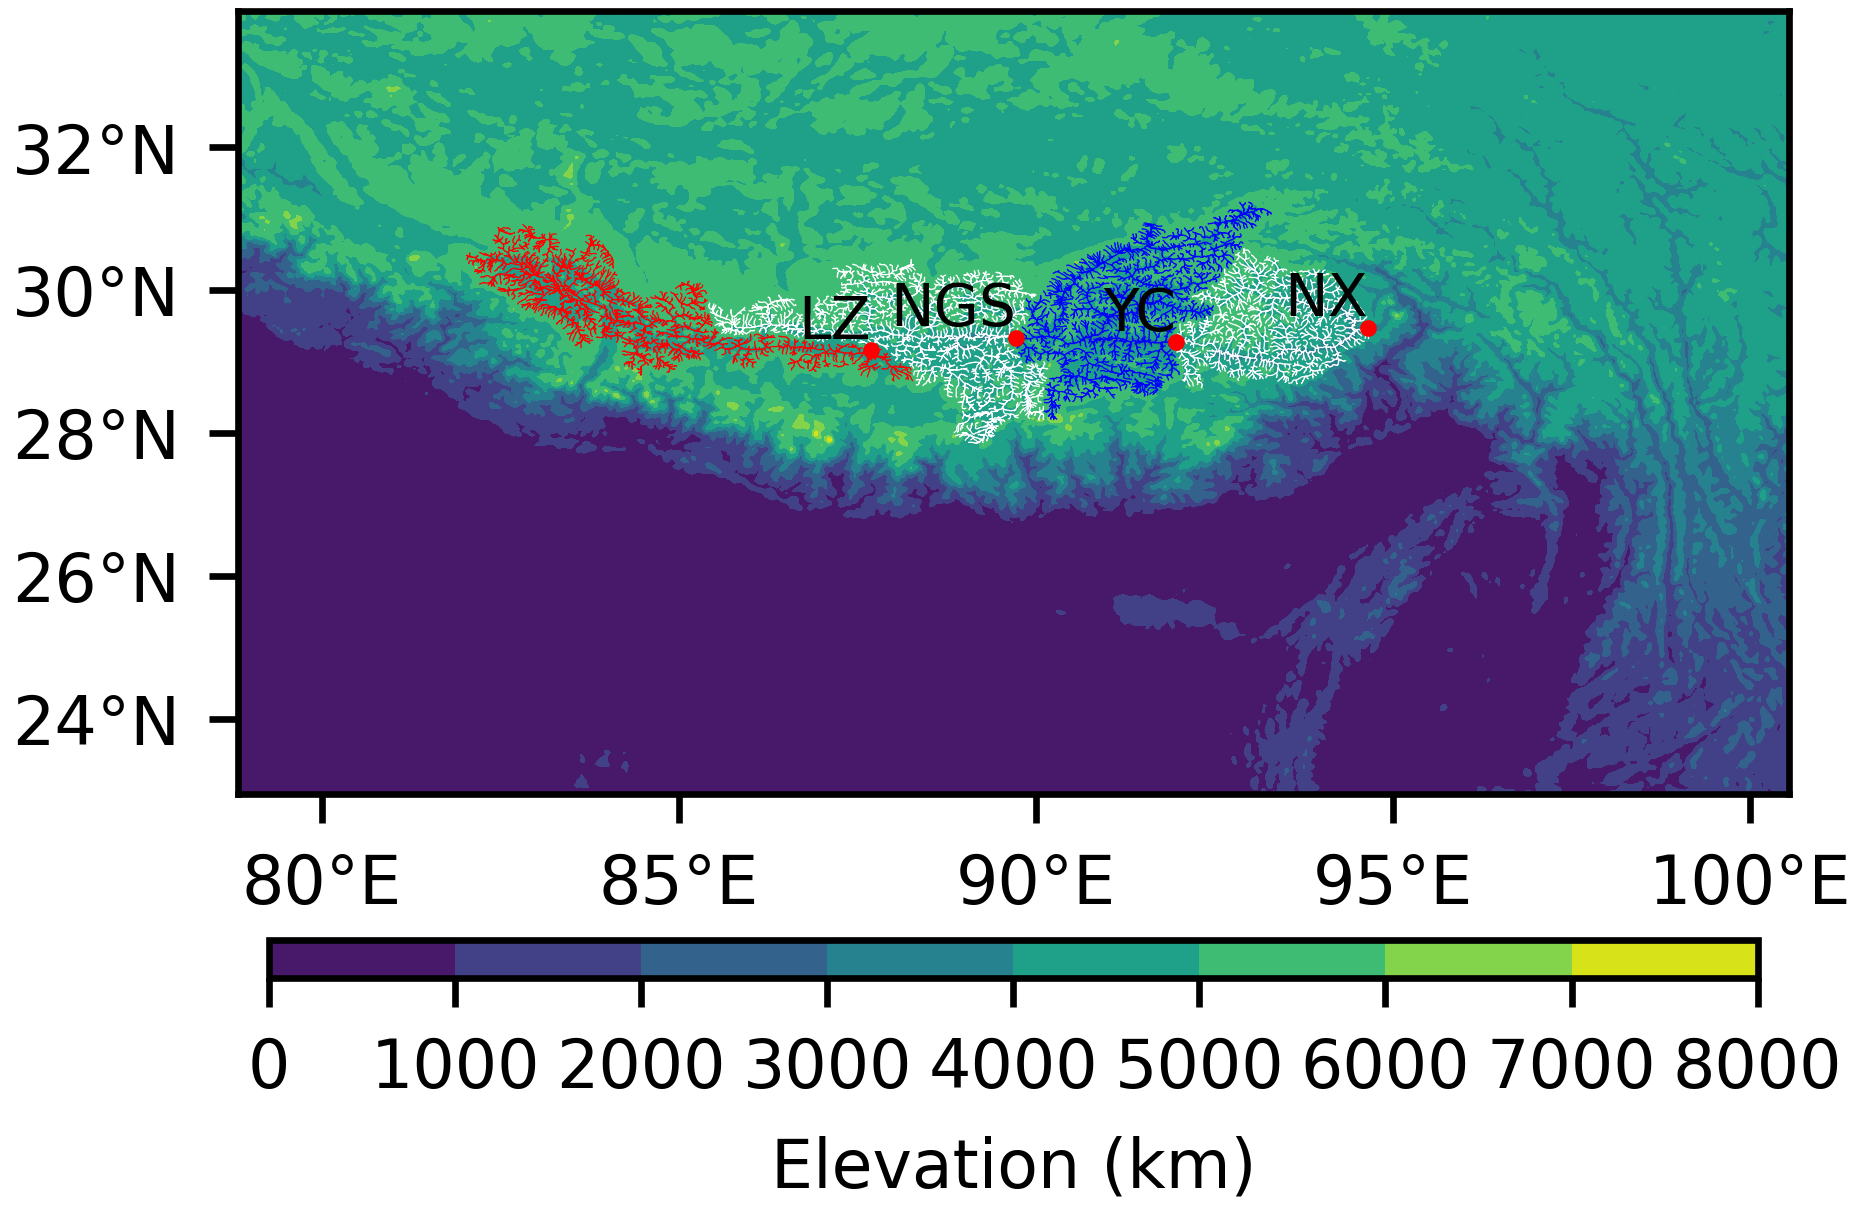

In [6]:
fig = plt.figure(figsize=(8/2.54, 6/2.54), dpi=FIGDPI, layout='constrained')
ax = fig.add_subplot(111)
cf = ax.contourf(lon, lat, hgt)
for i in range(rivnet.height):
    if rivnet[i, 'gauge'] == 'Lazi':
        color = 'r'
    elif rivnet[i, 'gauge'] == 'Nagesha':
        color = 'y'
    elif rivnet[i, 'gauge'] == 'Yangcun':
        color = 'b'
    else:
        color = 'w'
    ax.plot(rivnet[i, 'lon'], rivnet[i, 'lat'], color=color, linewidth=0.15)
for gaugename, gaugelat, gaugelon in gauge.select(['gauge', 'lat', 'lon']).iter_rows():
    gaugeshortname = {"Nuxia": "NX", "Yangcun": "YC", "Nugesha":"NGS", "Lazi":"LZ"}[gaugename]
    # gaugeshortname = {"Nuxia": "奴下", "Yangcun": "杨村", "Nugesha":"努各沙", "Lazi":"拉孜"}[gaugename]
    ax.plot(gaugelon, gaugelat, 'ro', markersize=1)
    ax.text(gaugelon, gaugelat, gaugeshortname, fontsize=7, ha='right', va='bottom')
cb = plt.colorbar(ax=ax, mappable=cf, orientation='horizontal', aspect=40, pad=0.02, shrink=0.96)
cb.set_label("Elevation (km)", fontsize=8)
ax.set_aspect('equal')
ax.set_xticks([80, 85, 90, 95, 100])
ax.set_xticklabels(["80°E", "85°E", "90°E", "95°E", "100°E"])
ax.set_yticks([24, 26, 28, 30, 32])
ax.set_yticklabels(["24°N", "26°N", "28°N", "30°N", "32°N"])

fig.savefig(FIGROOT.joinpath("domain").with_suffix(FIGSUFFIX), bbox_inches='tight')